# Multimode Interferometers (MMIs)

MMIs are devices that are used to combine and split light in a predictable way. They are designed not only to output a certain fraction of the input power, but are also designed so that the outputs have a certain phase difference. The basic design of an MMI includes the multimode region (a.k.a the body of the MMI) which is simple a multimode waveguide. This means, generally, that it will support more than three modes. Tapers that gradually widen the input and output waveguides as they go in and out of this multimode region are also common. MMIs are denoted by the number of input and output ports they have, with an NxM MMI having N input ports and M output ports.

<div style="text-align: center;">

![1x2mmi](https://github.com/BYUCamachoLab/Photonics-Bootcamp/blob/main/book/images/Notebook_Images/mmi1x2.png?raw=true)
![2x2mmi](https://github.com/BYUCamachoLab/Photonics-Bootcamp/blob/main/book/images/Notebook_Images/mmi2x2.png?raw=true)

</div>


<div style="text-align: center;">

A 1x2 and 2x2 MMI

</div>

### Self-Imaging

An "image" is a place where the electric fields are replicas of the electric field of the input. They occur periodically in MMIs at distances determined by the equation:

** INSERT EQUATION **

The images are created from light reflecting off of the walls of the multimode region and interfering constructively or destructively with other reflections. This self-imaging is how MMIs are able to combine and split light. For example, if you wanted a 2x2 MMI that splits light from one input port into another, you would find the length at which there are two images present in the MMI, and put the output ports there.

Self-imaging can work in this "forwards" way to split light and it can also work "backwards" to combine light. In other words, if you wanted to combine light with an MMI instead of split it, you could excite waves going into the output ports, and get a combined image of them at an input port based on the same physical mechanism.

<Axes: xlabel='X', ylabel='Y'>

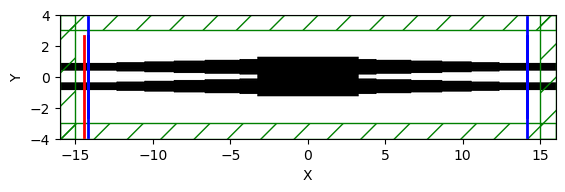

In [12]:
# Some sort of MMI simulation so can see self-imaging?
import meep as mp
import gdsfactory as gf
import tidy3d
from gdsfactory.simulation.gmeep import get_simulation
from gdsfactory.simulation.gmeep.get_simulation import get_meep_geometry_from_component

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

# Define wavelength in um
wvl = 1.55

# # Define cell and geometric parameters
resolution = 20
dpml = 1
pad = 1
## CHANGE THE MMI LENGTH SLIGHTLY TO SEE HOW THE POWER SPLITTING RATIO ##
length_mmi = 5.5
mmi = gf.components.mmi2x2(length_mmi=length_mmi)

Sx = dpml + -(mmi.ports["o1"].x) + (mmi.ports["o4"].x) + dpml
Sy = dpml + pad + -(mmi.ports["o1"].y) + -(mmi.ports["o4"].y) + pad + dpml
cell_size = mp.Vector3(Sx,Sy)

# Extend the ports to match the length of the cell
mmi = gf.components.extend_ports(mmi, port_names=["o1","o2","o3","o4"], length=1)

# Add PML (perfectly matched layers)
pml = [mp.PML(dpml)]

# Using the gdsfactory function, get the mmi geometry
geometry = get_meep_geometry_from_component(mmi)

# Put a pulse Eigenmode source at beginning of one waveguide
fcen = 1 / wvl
width = 0.1
fwidth = width * fcen
src=mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [mp.EigenModeSource(src=src, eig_band=1,
        eig_kpoint = (1,0),
        size=mp.Vector3(0,1),
        center=mp.Vector3(-mmi.ports["o1"].x+dpml+1, -mmi.ports["o1"].y/2))
        ]

# Create simulation dictionary
sim = get_simulation(mmi,
    resolution= 20,
    tpml= 1,
    port_source_offset= 0.2,
    port_monitor_offset= -0.1,
    distance_source_to_monitors= 0.3,)
sim['sim'].sources = sim['sources']
sim['sim'].cell_size.y = 8
sim['sim'].cell_size.x = 32
# Show simulation set-up
sim['sim'].plot2D()

In [13]:
from PIL import Image
import glob
import os

# Capture electric field intensity over time and output into a gif
sim['sim'].run(mp.at_beginning(mp.output_epsilon),
        mp.to_appended("ez", mp.at_every(2, mp.output_efield_z)),
        until=200)

# Generate pngs from the simulation output
# The line that worked in my workspace
os.system("h5topng -t 0:99 -R -Zc /home/ebang4/miniconda3/envs/h5utils/share/h5utils/colormaps/RdBu -A /home/ebang4/Github/Photonics-Bootcamp/book/pages/eps-000000.00.h5 -a /home/ebang4/miniconda3/envs/h5utils/share/h5utils/colormaps/gray /home/ebang4/Github/Photonics-Bootcamp/book/pages/ez.h5")

# This line assumes that their colormaps are working and that they are in the same directory as the output files
# also that h5py is installed
# If you have a problem with h5utils, see note below

# os.system("h5topng -t 0:299 -R -Zc RdBu -A eps-000000.00.h5 -a gray ez.h5")

# Create a gif from the pngs
frames = []
imgs = glob.glob("ez.t*")
imgs.sort()
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

 
# Save into a GIF file that loops forever
frames[0].save('ez.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               loop=0)

# Clean up workspace by deleting all generated images
for i in imgs: 
    os.remove(i)

The resulting GIF shows how power is split evenly between the two output ports based on the imaging within the MMI.

<div style="text-align: center;">

![2x2mmigif](https://github.com/BYUCamachoLab/Photonics-Bootcamp/blob/main/book/images/Notebook_Images/2x2mmi_ez.gif?raw=true)

</div>

### MMI Applications

MMIs have the advantage of being robust, or not very susceptible to manufacturing errors. In fact, at the optimum length for the MMI, the sensitivity is at a minimum. For example, when compared with directional couplers 

Mach-Zehnder optical switches, WDM, optical hybrids, polarization-diversity photodetectors.

### Sources

https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=372474

https://opg.optica.org/view_article.cfm?pdfKey=21e37623-43e8-4d94-b871476935a89af0_41580

https://arxiv.org/pdf/1405.6025.pdf